### <b><font color = 'purple'> HOMEWORK 06 - PART 2 DCGAN

#### <font color = 'purple'> Follow the DCGAN tutorial or write your own, experiment with different parameters or architectures (as you find suitable), document your findings, and visualize the generated results.

<font color = 'blue'> Importing the dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import torchvision
from PIL import Image

<font color = 'blue'> Performing the operation on Kaggle using the provided dataset i.e CelebA. Below are the parameters considered for DCGAN training. 

<font color = 'blue'>   Batch size is 128, to process the images in one iteration. \
<font color = 'blue'>The size of latent vector is set to 128.\
<font color = 'blue'>The number of filters in generator and discriminator is set to 128.\
<font color = 'blue'>Training epochs considered to be 10.
<font color = 'blue'>Learning rate for the optimizer is set to 0.0002

In [2]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

dataroot = "/kaggle/input/celeba-dataset/img_align_celeba" 

workers = 2
batch_size = 128
image_size = 64
nc = 3 
nz = 128 
ngf = 128 
ndf = 128 # 64 
num_epochs = 10  
lr = 0.0002  
beta1 = 0.5
ngpu = 1

<font color = 'blue'>Creating the dataset with the transform function, performing data augmenting techniques for our training dataset. Added Horizontal Flip in the transformation. 
Further, printing few images from the training set.

Number of images in dataset: 202599


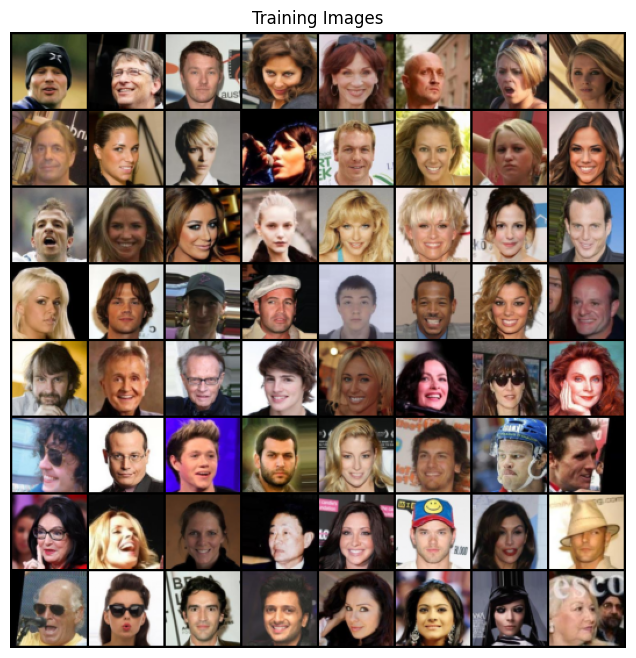

In [3]:
dataset = ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print(f"Number of images in dataset: {len(dataset)}")
images = next(iter(dataloader))

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

<font color = 'blue'>Initializing weights

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

<font color = 'blue'> <b>Generator:</b> This architecture starts with a latent vector of size nz as input, processed through a series of transposed convolutional layers that gradually increase the spatial dimensions while decreasing the number of channels. It ends in a final layer that outputs an RGB image of size 64 * 64 with nc (3) channels, using a Tanh activation function. This architecture involves multiple layers of up-sampling and non linear transformations. 

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
         
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator(ngpu).to(device)
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh

<font color = 'blue'> <b>Discriminator:</b> The discriminator architecture takes in RGB images sized (nc) * 64 * 64 and processes them through several layers. Each layer gradually reduces the image size while increasing the depth, allowing the model to learn intricate features of the input. It concludes with a final layer that outputs a single value, indicating the likelihood that the image is real rather than generated. By incorporating Leaky ReLU activations and Dropout layers, the model enhances its robustness and ability to generalize, and distinguish better between real and fake images.

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
         
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
         
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
        
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    

<font color = 'blue'> Loss function used is Binary Cross-Entropy Loss (BCELoss), which measures the performance of the discriminator in distinguishing between real and fake images. For generator's performance, a fixed noise tensor is created, consisting of random values of size (64, nz, 1, 1), which will be passed to the generator. The labels for real images are set to 1 and for fake images to 0.

<font color = 'blue'> For optimization, the Adam optimizer is utilized for both the generator and discriminator, with a learning rate of 0.0002 and betas set to (0.5, 0.999). This will allow the model to adjust weights and enhance the learning process.

In [7]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

<font color = 'blue'> Starting Training 

In [8]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        #Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # print(label)
        output = netD(real_cpu).view(-1)
        # print(output)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        # print(f'output-{output}')
        # print(f'label-{label}')
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/1583]	Loss_D: 2.1891	Loss_G: 9.3611	D(x): 0.7085	D(G(z)): 0.6976 / 0.0004
[0/10][50/1583]	Loss_D: 2.0106	Loss_G: 16.6916	D(x): 0.7282	D(G(z)): 0.4240 / 0.0000
[0/10][100/1583]	Loss_D: 2.1615	Loss_G: 6.3213	D(x): 0.5780	D(G(z)): 0.1542 / 0.0112
[0/10][150/1583]	Loss_D: 2.1718	Loss_G: 4.7795	D(x): 0.6837	D(G(z)): 0.6036 / 0.0470
[0/10][200/1583]	Loss_D: 1.8781	Loss_G: 2.3243	D(x): 0.3658	D(G(z)): 0.0996 / 0.1861
[0/10][250/1583]	Loss_D: 1.3571	Loss_G: 4.6536	D(x): 0.6648	D(G(z)): 0.3403 / 0.0334
[0/10][300/1583]	Loss_D: 0.8939	Loss_G: 3.7697	D(x): 0.6908	D(G(z)): 0.2040 / 0.0571
[0/10][350/1583]	Loss_D: 1.2110	Loss_G: 3.4990	D(x): 0.7382	D(G(z)): 0.3596 / 0.0991
[0/10][400/1583]	Loss_D: 1.3824	Loss_G: 4.0914	D(x): 0.6452	D(G(z)): 0.4507 / 0.0448
[0/10][450/1583]	Loss_D: 1.8263	Loss_G: 2.0177	D(x): 0.3748	D(G(z)): 0.1231 / 0.2737
[0/10][500/1583]	Loss_D: 1.1954	Loss_G: 2.1520	D(x): 0.6037	D(G(z)): 0.3648 / 0.1686
[0/10][550/1583]	Loss_D: 1.0707	Loss_G: 3

<font color='blue'> Plotting Losses for Discriminator and Generator

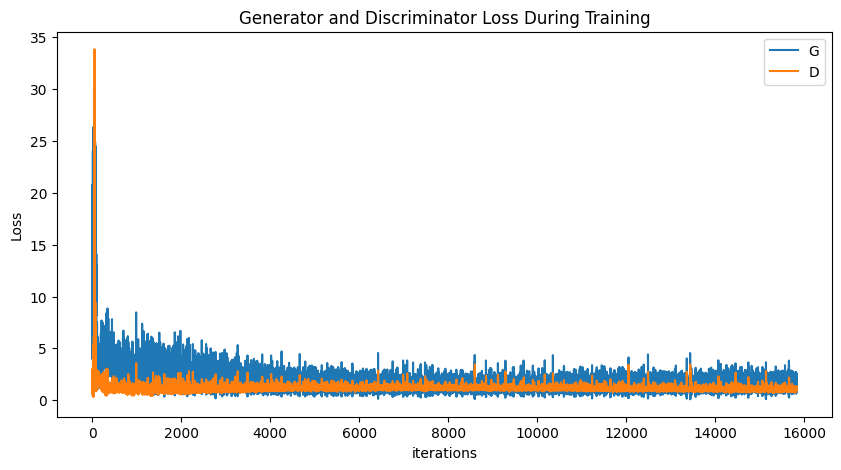

In [9]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

<font color = 'blue'> The graph illustrates the training process of a DCGAN on the CelebA dataset, showing both generator and discriminator losses over time. Initially, both losses are high, which is expected as the networks begin learning. As training progresses, the losses decrease and stabilize, indicating effective learning. The generator is getting better at creating realistic images, while the discriminator improves at distinguishing real from fake images. We do observe some fluctuations which is normal for the GANs. Overall, the balance between the two networks suggests successful training.

<font color='blue'> Showing Real and Fake Images side by side

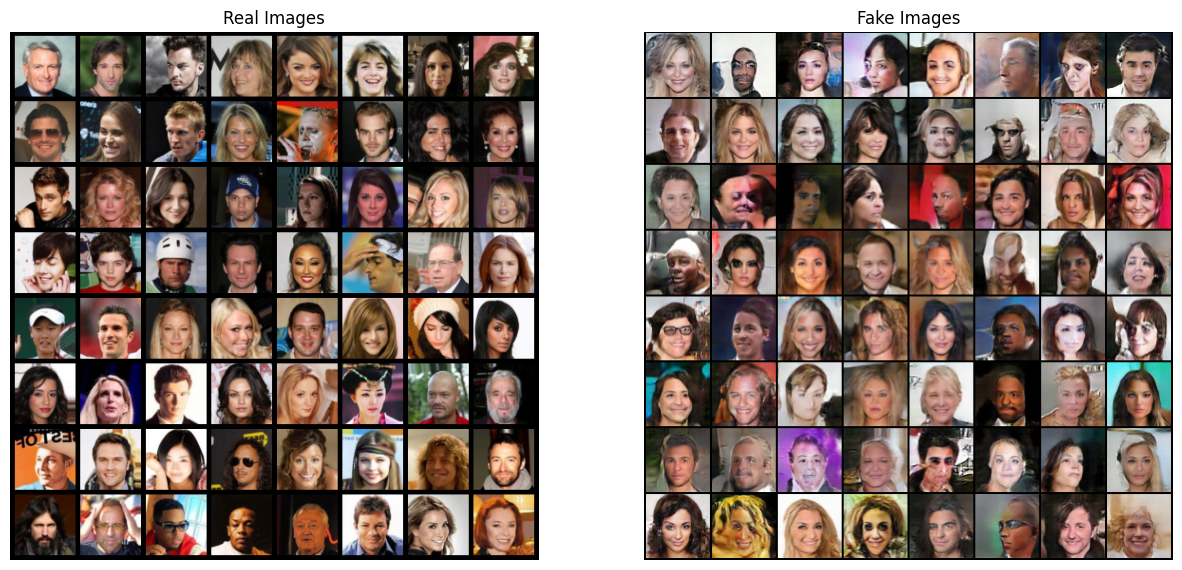

In [10]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

<font color = 'blue'> Saving the model 

In [13]:
torch.save(netG.state_dict(), 'Generator_model.pth')
torch.save(netD.state_dict(), 'Discriminator_model.pth')
torch.save(optimizerG.state_dict(), 'optimizerG.pth')
torch.save(optimizerD.state_dict(), 'optimizerD.pth')

## <font color = 'blue'> Thank You!